Primeras notas para probar las métricas necesarias para la segmentación de células

No se usa aumento de datos

Hay un ligero pre-procesamiento en ambos datasets para que sean del tamaño adecuado y puedan usarse con la U-Net.

In [0]:
from google.colab import drive
drive.mount('/content/drive')       #Accedemos a la cuenta de drive para cargar las imagenes y sus segmentaciones
from time import time
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.transform import resize

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Celda para importar las imagenes desde drive

Funciona bien con el dataset 2 ya que todas las imagenes son de 300x300

**NO funciona con el dataset 1** ya que las imagenes varían de tamaño

In [0]:
imagenes_t=skio.ImageCollection('/content/drive/My Drive/Colab Notebooks/WCB/Dataset2/*.bmp').concatenate()
groundT_t=skio.ImageCollection('/content/drive/My Drive/Colab Notebooks/WCB/Dataset2/*.png').concatenate()
print(imagenes_t.shape)
print(groundT_t.shape)

(100, 300, 300, 3)
(100, 300, 300)


Celda de prueba para añadir un borde falso a las imagenes del dataset 1 de modo que tengan tamaño 128x128, el color del borde se elije del mismo color que un pixel de la esquina de la imagen

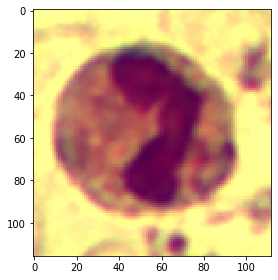

(116, 112, 3) uint8


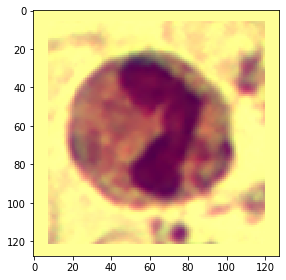

[[[1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  ...
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]]

 [[1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  ...
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]]

 [[1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  ...
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]]

 ...

 [[1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  ...
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]]

 [[1.        1.        0.5882353]
  [1.        1.        0.5882353]
  [1.        1.        0.5882353]
  ...
  [1.        1.        0.5882353]
  [1

In [0]:
img=np.ndarray((300,128,128,3),dtype=np.uint8)
temp=skio.imread('/content/drive/My Drive/Colab Notebooks/WCB/Dataset1/180.bmp')
f1=plt.figure()
skio.imshow(temp)
plt.show()
print(temp.shape,temp.dtype)
_x,_y,_=temp.shape
h_id=int((128-_x)/2)
v_id=int((128-_y)/2)
bordeh=np.ndarray((h_id,128,3),dtype=np.uint8)
bordev=np.ndarray((128,v_id,3),dtype=np.uint8)
bordeh[:,:,0]=temp[0,0,0]
bordeh[:,:,1]=temp[0,0,1]
bordeh[:,:,2]=temp[0,0,2]
bordev[:,:,0]=temp[0,0,0]
bordev[:,:,1]=temp[0,0,1]
bordev[:,:,2]=temp[0,0,2]
img[0,0:h_id,:,:]=bordeh                    #Rellenamos el borde horizontal superior
img[0,128-h_id:,:,:]=bordeh                 #Rellenamos el borde horizontal inferior
img[0,h_id:128-h_id,v_id:128-v_id,:]=temp   #Centramos la imagen original
img[0,:,128-v_id:,:]=bordev                 #Rellenamos el borde vertical derecho
img[0,:,0:v_id,:]=bordev                    #Rellenamos el borde vertical izquierdo
f2=plt.figure()
skio.imshow(img[0,...])
plt.show()
img=img.astype(np.float32)/255.0
print(img[0,...])
print(img.shape,img.dtype)

Celda para cargar las imagenes del dataset 1, normalizarlas y convertirlas a tipo float 32

(Se puede implementar como función para optimizar memoria, por ahora solo es para hacer pruebas)

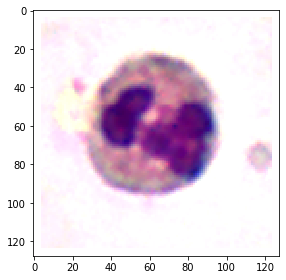

(300, 128, 128, 3) float32


In [0]:
imagenes=np.ndarray((300,128,128,3),dtype=np.uint8)
for i in range(1,301):
  img_id='/content/drive/My Drive/Colab Notebooks/WCB/Dataset1/{0:03}.bmp'.format(i)
  temporal=skio.imread(img_id)
  _x,_y,_=temporal.shape
  h_id=int((128-_x)/2)
  v_id=int((128-_y)/2)
  bordeh=np.ndarray((h_id,128,3),dtype=np.uint8)  
  bordev=np.ndarray((128,v_id,3),dtype=np.uint8)
  bordeh[:,:,0]=temporal[0,0,0]
  bordeh[:,:,1]=temporal[0,0,1]
  bordeh[:,:,2]=temporal[0,0,2]
  bordev[:,:,0]=temporal[0,0,0]
  bordev[:,:,1]=temporal[0,0,1]
  bordev[:,:,2]=temporal[0,0,2]
  imagenes[i-1,0:h_id,:,:]=bordeh                       #Rellenamos el borde horizontal superior
  imagenes[i-1,128-h_id:,:,:]=bordeh                    #Rellenamos el borde horizontal inferior
  imagenes[i-1,h_id:128-h_id,v_id:128-v_id,:]=temporal  #Centramos la imagen original
  imagenes[i-1,:,128-v_id:,:]=bordev                    #Rellenamos el borde vertical derecho
  imagenes[i-1,:,0:v_id,:]=bordev                       #Rellenamos el borde vertical izquierdo
ejemplo=plt.figure()
skio.imshow(imagenes[250,...])
plt.show()
imagenes=imagenes.astype(np.float32)/255.0
print(imagenes.shape,imagenes.dtype)

Celda para cargar las imagenes segmentadas por expertos del dataset 1, normalizarlas y convertirlas a tipo float 32

(Se puede implementar como función para optimizar memoria, por ahora solo es para hacer pruebas)

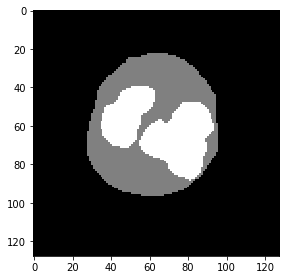

(300, 128, 128, 1) float32


In [0]:
groundT_t=np.ndarray((300,128,128),dtype=np.uint8)
for i in range(1,301):
  img_id='/content/drive/My Drive/Colab Notebooks/WCB/Dataset1/{0:03}.png'.format(i)
  temporal=skio.imread(img_id)
  _x,_y=temporal.shape
  h_id=int((128-_x)/2)
  v_id=int((128-_y)/2)
  bordeh=np.ndarray((h_id,128),dtype=np.uint8)  
  bordev=np.ndarray((128,v_id),dtype=np.uint8)
  bordeh[:,:]=temporal[0,0]
  bordev[:,:]=temporal[0,0]
  groundT_t[i-1,0:h_id,:]=bordeh                        #Rellenamos el borde horizontal superior
  groundT_t[i-1,128-h_id:,:]=bordeh                     #Rellenamos el borde horizontal inferior
  groundT_t[i-1,h_id:128-h_id,v_id:128-v_id]=temporal   #Centramos la imagen original
  groundT_t[i-1,:,128-v_id:]=bordev                     #Rellenamos el borde vertical derecho
  groundT_t[i-1,:,0:v_id]=bordev                        #Rellenamos el borde vertical izquierdo
ejemplo=plt.figure()
skio.imshow(groundT_t[250,...])
plt.show()
groundT=groundT_t[:,:,:,None].astype(np.float32)/255.0
print(groundT.shape,groundT.dtype)

Celda para normalizar las imagenes y recortarlas para que sean de 256x256 (ya que la U-Net utiliza imagenes con tamaño que sea multiplo de 32)

In [0]:
imagenes=imagenes_t[:,22:278,22:278,:].astype(np.float32)
groundT=groundT_t[:,22:278,22:278,None].astype(np.float32)
imagenes/=255.0
groundT/=255.0
print(groundT.shape)
print(imagenes.shape)
#x_train=imagenes[0:90,:,:,:]
#y_train=groundT[0:90,:,:,:]
#x_test=imagenes[90:,:,:,:]
#y_test=groundT[90:,:,:,:]
#print(x_train.shape)
#print(y_test.shape)

(100, 256, 256, 1)
(100, 256, 256, 3)


In [0]:
#Definimos las nuevas métricas que se van a usar
import tensorflow as tf

def O_Rate(y_true,y_pred):
  num_data = tf.cast(tf.shape(y_true), dtype=tf.float32)
  y_t=tf.reshape(y_true,shape=[-1])
  y_p=tf.reshape(y_pred,shape=[-1])
  uno=tf.constant(1.0,dtype=tf.float32)
  y_true_b=tf.round(y_t+0.1)
  y_pred_b=tf.round(y_p+0.1)
  Dp=tf.reduce_sum(y_true_b*y_pred_b)
  Qp=tf.reduce_sum(y_true_b*(uno-y_pred_b))
  Up=tf.reduce_sum(y_pred_b*(uno-y_true_b))
  return (Qp/(Up+Dp+0.0001))/num_data[0]

#Estas primeras usan menos parametros pero ambas son equivalentes en tabla de verdad y  en resultados
def U_Rate(y_true,y_pred):
  num_data = tf.cast(tf.shape(y_true), dtype=tf.float32)
  y_t=tf.reshape(y_true,shape=[-1])
  y_p=tf.reshape(y_pred,shape=[-1])
  uno=tf.constant(1.0,dtype=tf.float32)
  y_true_b=tf.round(y_t+0.1)
  y_pred_b=tf.round(y_p+0.1)
  Dp=tf.reduce_sum(y_true_b*y_pred_b) 
  Qp=tf.reduce_sum(y_true_b*(uno-y_pred_b))
  Up=tf.reduce_sum(y_pred_b*(uno-y_true_b))
  return (Up/(Up+Dp+0.0001))/num_data[0]

def Err_rate(y_true,y_pred):
  num_data = tf.cast(tf.shape(y_true), dtype=tf.float32)
  y_t=tf.reshape(y_true,shape=[-1])
  y_p=tf.reshape(y_pred,shape=[-1])
  uno=tf.constant(1.0,dtype=tf.float32)
  y_true_b=tf.round(y_t+0.1)
  y_pred_b=tf.round(y_p+0.1)
  Dp=tf.reduce_sum(y_true_b*y_pred_b)
  Qp=tf.reduce_sum(y_true_b*(uno-y_pred_b))
  Up=tf.reduce_sum(y_pred_b*(uno-y_true_b))
  return ((Qp+Up)/(Dp+0.0001))/num_data[0]

#Métricas mejoradas, implementadas por Edwin
def _static_binarization(x):
    """Take a TensorFlow Tensor object and statically binarize it.
    This function makes the assumption that `x`
     has values between 0 and 1. If the element value of `x` is >= 0.5,
    then an integer 1 is assigned, otherwise, an integer 0 is assigned.

    Args:
        x: Tensor to binarize

    Returns:
        new_x: Binarized tensor
    """
    new_x = tf.where(x >= 0.5, 1, 0)
    new_x = tf.cast(new_x, tf.float32)
    return new_x

def _up_dp_qp(x, y):
    """Obtain under, over and overall error segmentation rates.
    By binarizing a ground truth and predicted segmentation maps,
    this function obtains:
    - Qp, the number of pixels that should
        be included in the segmentation result but are not
    - Up, the number of pixels that should be
        excluded from the segmentation result but actually included
    - Dp, the number of pixels that should be included in the segmentation result
        and are also actually included.
    This implementation leverages logical operations and invertions for
    a faster computation of the values.

    Args:
        x: The ground truth
        y: The predicted value

    Returns:
        u_p: the calculated value for Up
        d_p: the calculated value for Dp
        q_p: the calculated value for Qp
    """
    y_t = tf.reshape(x, shape=[-1])
    y_p = tf.reshape(y, shape=[-1])
    y_t = _static_binarization(y_t)
    y_p = _static_binarization(y_p)
    d_p = tf.reduce_sum(y_t * y_p)
    q_p = tf.reduce_sum(y_t * (1.0 - y_p))
    u_p = tf.reduce_sum(y_p * (1.0 - y_t))
    return u_p, d_p, q_p

def o_rate(y_true, y_pred):
    """Calculate the over segmentation error.
    Assuming `y_true` and `y_pred` are images, this function calculates
    the overall segmentation error, OR, defined as:

    Args:
        y_true: with the ground truth.
        y_pred: with the predicted value.

    Returns:
        result: Constant Tensor with the OR value.
    """
    u_p, d_p, q_p = _up_dp_qp(y_true, y_pred)
    # Add a smoothing factor of 1.0 to prevent division by zero
    result = q_p / (u_p + d_p + 1.0)
    # Use the number of images as a means of normalizing the result
    num_data = tf.cast(tf.shape(y_true), result.dtype)
    result = tf.cast(result / num_data[0], tf.float32)
    return result

def u_rate(y_true, y_pred):
    """Calculate the under segmentation error.
    Assuming `y_true` and `y_pred` are images, this function calculates
    the overall segmentation error, UR, defined as:
    UR = Up / (Up + Dp)

    Args:
        y_true: with the ground truth.
        y_pred: with the predicted value.

    Returns:
        result: Constant Tensor with the UR value.
    """
    u_p, d_p, _ = _up_dp_qp(y_true, y_pred)
    # Add a smoothing factor of 1.0 to prevent division by zero
    result = u_p / (u_p + d_p + 1.0)
    # Use the number of images as a means of normalizing the result
    num_data = tf.cast(tf.shape(y_true), result.dtype)
    result = tf.cast(result / num_data[0], tf.float32)
    return result

def err_rate(y_true, y_pred):
    """Calculate the overall segmentation error.
    Assuming `y_true` and `y_pred` are images, this function calculates
    the overall segmentation error, ER, defined as:
    ER = (Qp + Up) / Dp

    Args:
        y_true: with the ground truth.
        y_pred: with the predicted value.

    Returns:
        result: Constant Tensor with the ER value.
    """
    u_p, d_p, q_p = _up_dp_qp(y_true, y_pred)
    # Add a smoothing factor of 1.0 to prevent division by zero
    result = (q_p + u_p) / (d_p + 1.0)
    # Use the number of images as a means of normalizing the result
    num_data = tf.cast(tf.shape(y_true), result.dtype)
    result = tf.cast(result / num_data[0], tf.float32)
    result = tf.math.abs(result)
    return result


In [0]:
#Modelo de la U-Net implementado por Edwin, codigo extraido del repositorio de DCI-NET/segnet
from tensorflow import keras as K

def unet(input_size=(256, 256, 3)):
    """
    Implementation of the U-Net model, using Concatenation instead of
    crop and place for the semantic gap.
    Arguments:
        input_size: Tuple of three integer values that correspond to the image
                    information, namely (height, width, channels).
    Returns:
        model: A tf.keras.Model instance
    """
    # Take in the inputs
    inputs = K.layers.Input(input_size)
    # First encoder block
    conv_1 = K.layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv_1 = K.layers.Conv2D(64, 3, activation="relu", padding="same")(conv_1)
    pool_1 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    # Second encoder block
    conv_2 = K.layers.Conv2D(128, 3, activation="relu", padding="same")(pool_1)
    conv_2 = K.layers.Conv2D(128, 3, activation="relu", padding="same")(conv_2)
    pool_2 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    # Third encoder block
    conv_3 = K.layers.Conv2D(256, 3, activation="relu", padding="same")(pool_2)
    conv_3 = K.layers.Conv2D(256, 3, activation="relu", padding="same")(conv_3)
    pool_3 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    # Fourth encoder block
    conv_4 = K.layers.Conv2D(512, 3, activation="relu", padding="same")(pool_3)
    conv_4 = K.layers.Conv2D(512, 3, activation="relu", padding="same")(conv_4)
    drop_4 = K.layers.Dropout(0.5)(conv_4)
    pool_4 = K.layers.MaxPooling2D(pool_size=(2, 2))(drop_4)
    # Encoder-decoder conection
    conv_5 = K.layers.Conv2D(1024, 3, activation="relu", padding="same")(pool_4)
    conv_5 = K.layers.Conv2D(1024, 3, activation="relu", padding="same")(conv_5)
    drop_5 = K.layers.Dropout(0.5)(conv_5)
    # First decoder block
    up_6 = K.layers.UpSampling2D(size=(2, 2))(drop_5)
    up_6 = K.layers.Conv2D(512, 2, activation="relu", padding="same")(up_6)
    # Concatenation of first decoder and fourth encoder blocks
    merge_6 = K.layers.Concatenate()([conv_4, up_6])
    conv_6 = K.layers.Conv2D(512, 3, activation="relu", padding="same")(merge_6)
    conv_6 = K.layers.Conv2D(512, 3, activation="relu", padding="same")(conv_6)
    # Second decoder block
    up_7 = K.layers.UpSampling2D(size=(2, 2))(conv_6)
    up_7 = K.layers.Conv2D(256, 2, activation="relu", padding="same")(up_7)
    # Concatenation of second decoder and third encoder block
    merge_7 = K.layers.Concatenate()([conv_3, up_7])
    conv_7 = K.layers.Conv2D(256, 3, activation="relu", padding="same")(merge_7)
    conv_7 = K.layers.Conv2D(256, 3, activation="relu", padding="same")(conv_7)
    # Third decoder block
    up_8 = K.layers.UpSampling2D(size=(2, 2))(conv_7)
    up_8 = K.layers.Conv2D(128, 2, activation="relu", padding="same")(up_8)
    # Concatenation of third decoder and second encoder block
    merge_8 = K.layers.Concatenate()([conv_2, up_8])
    conv_8 = K.layers.Conv2D(128, 3, activation="relu", padding="same")(merge_8)
    conv_8 = K.layers.Conv2D(128, 3, activation="relu", padding="same")(conv_8)
    # Fourth decoder block
    up_9 = K.layers.UpSampling2D(size=(2, 2))(conv_8)
    up_9 = K.layers.Conv2D(64, 2, activation="relu", padding="same")(up_9)
    # Concatenation of fourth decoder and first encoder block
    merge_9 = K.layers.Concatenate()([conv_1, up_9])
    conv_9 = K.layers.Conv2D(64, 3, activation="relu", padding="same")(merge_9)
    conv_9 = K.layers.Conv2D(64, 3, activation="relu", padding="same")(conv_9)
    # Output of U-Net
    conv_9 = K.layers.Conv2D(2, 3, activation="relu", padding="same")(conv_9)
    conv_10 = K.layers.Conv2D(1, 1, activation="sigmoid")(conv_9)

    model = K.models.Model(inputs=[inputs], outputs=[conv_10])
    return model

#Modelo donde agrego el regularizador L2
def unetl2(input_size=(256, 256, 3)):
  # Take in the inputs
    inputs = K.layers.Input(input_size)
    # First encoder block
    conv_1 = K.layers.Conv2D(64, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(inputs)
    conv_1 = K.layers.Conv2D(64, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_1)
    pool_1 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    # Second encoder block
    conv_2 = K.layers.Conv2D(128, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(pool_1)
    conv_2 = K.layers.Conv2D(128, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_2)
    pool_2 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    # Third encoder block
    conv_3 = K.layers.Conv2D(256, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(pool_2)
    conv_3 = K.layers.Conv2D(256, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_3)
    pool_3 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    # Fourth encoder block
    conv_4 = K.layers.Conv2D(512, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(pool_3)
    conv_4 = K.layers.Conv2D(512, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_4)
#drop_4 = K.layers.Dropout(0.5)(conv_4)
#pool_4 = K.layers.MaxPooling2D(pool_size=(2, 2))(drop_4)
    pool_4 = K.layers.MaxPooling2D(pool_size=(2, 2))(conv_4)
    # Encoder-decoder conection
    conv_5 = K.layers.Conv2D(1024, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(pool_4)
    conv_5 = K.layers.Conv2D(1024, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_5)
#drop_5 = K.layers.Dropout(0.5)(conv_5)
    # First decoder block
#up_6 = K.layers.UpSampling2D(size=(2, 2))(drop_5)
    up_6 = K.layers.UpSampling2D(size=(2, 2))(conv_5)
    up_6 = K.layers.Conv2D(512, 2, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(up_6)
    # Concatenation of first decoder and fourth encoder blocks
    merge_6 = K.layers.Concatenate()([conv_4, up_6])
    conv_6 = K.layers.Conv2D(512, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(merge_6)
    conv_6 = K.layers.Conv2D(512, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_6)
    # Second decoder block
    up_7 = K.layers.UpSampling2D(size=(2, 2))(conv_6)
    up_7 = K.layers.Conv2D(256, 2, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(up_7)
    # Concatenation of second decoder and third encoder block
    merge_7 = K.layers.Concatenate()([conv_3, up_7])
    conv_7 = K.layers.Conv2D(256, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(merge_7)
    conv_7 = K.layers.Conv2D(256, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_7)
    # Third decoder block
    up_8 = K.layers.UpSampling2D(size=(2, 2))(conv_7)
    up_8 = K.layers.Conv2D(128, 2, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(up_8)
    # Concatenation of third decoder and second encoder block
    merge_8 = K.layers.Concatenate()([conv_2, up_8])
    conv_8 = K.layers.Conv2D(128, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(merge_8)
    conv_8 = K.layers.Conv2D(128, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_8)
    # Fourth decoder block
    up_9 = K.layers.UpSampling2D(size=(2, 2))(conv_8)
    up_9 = K.layers.Conv2D(64, 2, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(up_9)
    # Concatenation of fourth decoder and first encoder block
    merge_9 = K.layers.Concatenate()([conv_1, up_9])
    conv_9 = K.layers.Conv2D(64, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(merge_9)
    conv_9 = K.layers.Conv2D(64, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_9)
    # Output of U-Net
    conv_9 = K.layers.Conv2D(2, 3, activation="relu", padding="same",kernel_regularizer=K.regularizers.l2(0.005))(conv_9)
    conv_10 = K.layers.Conv2D(1, 1, activation="sigmoid")(conv_9)

    model = K.models.Model(inputs=[inputs], outputs=[conv_10])
    return model

Celda con un ciclo para correr el cross-validation

Se guarda el modelo con la menor perdida y el menor error total (del entrenamiento)

Se guarda en formato csv el diccionario con los resultados de las metricas (tanto del entrenamiento como de la validacion) 

Para el dataset 2 un batch_size de 3 nos da 30 iteraciones por epoca (Se uso la función KFold de scikit-learn para generar los índices el cross-validation con Suffle=True y random_state=1234)

Para el dataset 1 un batch_size de 9 nos da 30 iteraciones por epoca 

(Cuidado con los paths si se quiere volver a correr, puede sobre-escribir algunos de los resultados ya hechos. Se debe tener una ruta válida, en este caso todo se guarda en Drive)

In [0]:
#Prueba del KFold, los pindices se generan aleatoreamente
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import KFold
import pandas as pd
partes=KFold(n_splits=10,shuffle=True,random_state=1234)
resultados=[]
contador=0
for train_id,test_id in partes.split(imagenes):
  print("Iteracion: ",contador)
  print(train_id,test_id) #Generamos aleatoriamente los índices para train y test
  path1='/content/drive/My Drive/Colab Notebooks/Pruebas/dataset1/1000epochs_10KF_newMetrics/unet_model_loss_iter{0}.hdf5'.format(contador)
  Cback1=K.callbacks.ModelCheckpoint(filepath=path1,monitor='loss',verbose=0,save_best_only=True)
  path2='/content/drive/My Drive/Colab Notebooks/Pruebas/dataset1/1000epochs_10KF_newMetrics/unet_model_Err_iter{0}.hdf5'.format(contador)
  Cback2=K.callbacks.ModelCheckpoint(filepath=path2,monitor='Err_rate',verbose=0,save_best_only=True,mode='min')
  x_train=imagenes[train_id,...]
  y_train=groundT[train_id,...]
  x_test=imagenes[test_id,...]
  y_test=groundT[test_id,...]
  if(contador==7):
    modelo=unetl2(input_size=(128,128,3))
    modelo.compile(optimizer=K.optimizers.SGD(learning_rate=0.06,momentum=0.2),loss='binary_crossentropy',metrics=[O_Rate,U_Rate,Err_rate])
    t1=time()
    historia=modelo.fit(x_train,y_train,batch_size=3,epochs=1000,verbose=1,validation_data=(x_test,y_test),callbacks=[Cback1,Cback2])
    t2=time()
    print("Tiempo de entrenamiento: ",t2-t1)
    resultados.append(historia) #Guardamos los resultados de cada entrenamiento en una lista
    df=pd.DataFrame(historia.history)
    csv_name='/content/drive/My Drive/Colab Notebooks/Pruebas/dataset1/1000epochs_10KF_newMetrics/1000epoch_10KF_iter{0}_min_{1:.4f}.csv'.format(contador,(t2-t1)/60.0)
    df.to_csv(csv_name) 
  contador+=1

Iteracion:  0
[  0   1   2   3   4   5   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  68  69  70  71  72  74  75  76  78
  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 103 104 105 107 108 109 110 113 114 116 117 118 119 120
 121 122 123 124 126 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 147 148 149 150 151 152 153 154 156 157 158 159 160
 161 162 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 202 203 204 205 206 207 208 209 210 211 212 213 215 216 217 218 219 220
 221 223 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 263 264 265 266 267 268 269 

In [0]:
#Codigo para guardar los resultados mediante una descarga del navegador
import pandas as pd
from google.colab import files
df=pd.DataFrame(resultados[0].history)  #Convertimos a DataFrame el dictionario con las metricas y perdidas
name='1000epoch_10KF_iter{0}_min_{1:.4f}.csv'.format(4,(t2-t1)/60.0)  #Con format() podemos agregar el iterador en un ciclo for
df.to_csv(name)                         #guardamos en formato csv el dictionario
files.download(name)                    #Descargamos el archivo en la pc

Prueba para crear los mapas de segmentación utilizando un modelo hecho durante la validación cruzada con el Dataset 1.

---



(1, 128, 128, 1)


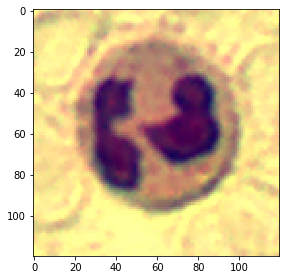

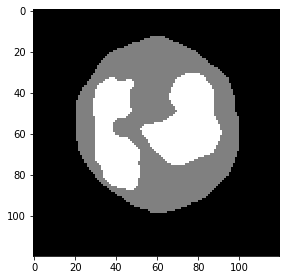

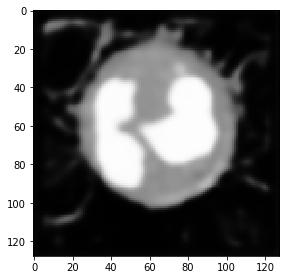

In [0]:
#Pruebas de la U-Net con weight decay=0.005 (L2 regularizer) en todas las capas de convolucion del modelo orignal
from time import time
Unet_proof=K.models.load_model('/content/drive/My Drive/Colab Notebooks/Pruebas/dataset1/1000epochs_10KF_newMetrics/unet_model_loss_iter0.hdf5',custom_objects={"O_Rate":O_Rate,"U_Rate":U_Rate,"Err_rate":Err_rate})
aux=np.ndarray((1,128,128,3),dtype=np.float32)
aux[0,...]=imagenes[5,...]
results=Unet_proof.predict(aux)
print(results.shape)
proof=np.ndarray((128,128),dtype=np.uint8)
for i in range(128):
  for j in range(128):
    proof[i,j]=results[0,i,j,0]*255
f1=plt.figure()
skio.imshow(skio.imread('/content/drive/My Drive/Colab Notebooks/WCB/Dataset1/006.bmp'))
f2=plt.figure()
skio.imshow(skio.imread('/content/drive/My Drive/Colab Notebooks/WCB/Dataset1/006.png'))
f3=plt.figure()
skio.imshow(proof)
plt.show()

Prueba para guardar directamente en un directorio el archivo .csv generado con pandas a partir del diccionario de las métricas (Es lo que se usa en el celda del KFold).

También hay una prueba para añadirle información al diccionario, lo cual serviría para agregar un diccionario de parametros, nombre de la función, tiempo de ejecución, etc, en el archivo csv (Obsoleto, ya se hace con el decorador de Gustavo)

In [0]:
import pandas as pd
dict1={'hola':[1,2,3,4,5,6,7,8],'adios':[1,2,3,4,5,6,7,8]}
dict1.update({'time':4324.23})
print(dict1)
p=pd.DataFrame(dict1)
p.to_csv('/content/drive/My Drive/Colab Notebooks/proof.csv')

{'hola': [1, 2, 3, 4, 5, 6, 7, 8], 'adios': [1, 2, 3, 4, 5, 6, 7, 8], 'time': 4324.23}


Pruebas para la implementación de las métricas, utilizando el promedio con la primer dimensión del tensor de entrada [Funciona como se espera]

---



In [0]:
a=np.ndarray((1,3,3,1))                   #Este arreglo será el y_true
b=np.ndarray((1,3,3,1))                   #Este arreglo será el y_pred
a[0,0,0,0]=0.98
a[0,0,1,0]=0.10
a[0,2,0]=0.5
a[0,1,0,0]=0.7
a[0,1,1,0]=0.2
a[0,1,2,0]=0.35
a[0,2,0,0]=0.82
a[0,2,1,0]=0.6
a[0,2,2,0]=0.52
print("Arreglo de prueba y_true: ",a.flatten(),", Con shape original: ",a.shape)
b[0,0,0,0]=0.98
b[0,0,1,0]=0.2
b[0,0,2,0]=0.3
b[0,1,0,0]=0.4
b[0,1,1,0]=0.8
b[0,1,2,0]=0.7
b[0,2,0,0]=0.1
b[0,2,1,0]=0.6
b[0,2,2,0]=0.52
print("Arreglo de prueba y_pred: ",b.flatten(),", Con shape original: ",b.shape)
t_true=tf.convert_to_tensor(a,dtype=tf.float32)
t_pred=tf.convert_to_tensor(b,dtype=tf.float32)
over_seg=O_Rate(t_true,t_pred)
under_seg=U_Rate(t_true,t_pred)
over_err=Err_rate(t_true,t_pred)
sesi=tf.Session()
t_shape=t_true.get_shape().as_list()
or_value=sesi.run(over_seg)
ur_value=sesi.run(under_seg)
err_value=sesi.run(over_err)
print("Tensor original shape: ",t_shape,", Number of elements: ",len(t_shape))
print("OR=",or_value)
print("UR=",ur_value)
print("ERR=",err_value)

Arreglo de prueba y_true:  [0.98 0.1  0.3  0.7  0.2  0.35 0.82 0.6  0.52] , Con shape original:  (1, 3, 3, 1)
Arreglo de prueba y_pred:  [0.98 0.2  0.3  0.4  0.8  0.7  0.1  0.6  0.52] , Con shape original:  (1, 3, 3, 1)
Tensor original shape:  [1, 3, 3, 1] , Number of elements:  4
OR= 0.399992
UR= 0.399992
ERR= 1.3332889


Prueba de la última implementación de las métricas

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import KFold
import pandas as pd
partes=KFold(n_splits=10,shuffle=True,random_state=1234)
resultados=[]
contador=0
for train_id,test_id in partes.split(imagenes):
  print("Iteracion: ",contador)
  print(train_id,test_id) #Generamos aleatoriamente los índices para train y test
  x_train=imagenes[train_id,...]
  y_train=groundT[train_id,...]
  x_test=imagenes[test_id,...]
  y_test=groundT[test_id,...]
  if(contador==0):
    modelo=unetl2(input_size=(128,128,3))
    modelo.compile(optimizer=K.optimizers.SGD(learning_rate=0.06,momentum=0.2),loss='binary_crossentropy',metrics=[o_rate,u_rate,err_rate])
    t1=time()
    historia=modelo.fit(x_train,y_train,batch_size=3,epochs=1000,verbose=1,validation_data=(x_test,y_test))
    t2=time()
    print("Tiempo de entrenamiento: ",t2-t1)
    resultados.append(historia) #Guardamos los resultados de cada entrenamiento en una lista
    df=pd.DataFrame(historia.history)
    csv_name='/content/drive/My Drive/Colab Notebooks/Pruebas/dataset1/1000epochs_10KF_newMetrics/1000epoch_10KF_iter{0}_min_{1:.4f}.csv'.format(contador,(t2-t1)/60.0)
    df.to_csv(csv_name) 
  contador+=1

Iteracion:  0
[  0   1   2   3   4   5   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  68  69  70  71  72  74  75  76  78
  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 103 104 105 107 108 109 110 113 114 116 117 118 119 120
 121 122 123 124 126 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 147 148 149 150 151 152 153 154 156 157 158 159 160
 161 162 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 202 203 204 205 206 207 208 209 210 211 212 213 215 216 217 218 219 220
 221 223 225 226 227 228 229 230 231 232 233 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 263 264 265 266 267 268 269 

ValueError: ignored